### Ensure to upload the following files, if training on Google Colab
- CustomDataModule.py
- model.py
- processing.py
- MS_SSIM_L1_lOSS.py
- checkpoints/ (if training from checkpoint)

In [4]:
! pip3 install torch torchvision torchaudio
! pip3 install numpy
! pip3  install matplotlib
! pip3 install pytorch-lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import torch
import torchvision
from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import time
import os
from MS_SSIM_L1_loss import MS_SSIM_L1_LOSS
from processing import grey_to_rgb, get_latest_epoch, resume, checkpoint, imshow, get_epoch
from model import Autoencoder
from CustomDataModule import CustomDataModule

### Mount the drive from google colab

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Unzip the data

In [4]:
!unzip drive/MyDrive/video_data.zip

Archive:  drive/MyDrive/video_data.zip
   creating: video_data/
   creating: video_data/V0/
  inflating: video_data/V0/frame_Giving_money_vid_29460.jpg  
  inflating: video_data/V0/frame_Giving_money_vid_360.jpg  
  inflating: video_data/V0/frame_Giving_money_vid_390.jpg  
  inflating: video_data/V0/frame_Giving_money_vid_420.jpg  
  inflating: video_data/V0/frame_Giving_money_vid_450.jpg  
  inflating: video_data/V0/frame_Giving_money_vid_480.jpg  
  inflating: video_data/V0/frame_Giving_money_vid_510.jpg  
  inflating: video_data/V0/frame_Giving_money_vid_540.jpg  
  inflating: video_data/V0/frame_Giving_money_vid_570.jpg  
  inflating: video_data/V0/frame_Giving_money_vid_600.jpg  
  inflating: video_data/V0/frame_Giving_money_vid_630.jpg  
  inflating: video_data/V0/frame_Giving_money_vid_660.jpg  
  inflating: video_data/V0/frame_Giving_money_vid_690.jpg  
  inflating: video_data/V0/frame_Giving_money_vid_720.jpg  
  inflating: video_data/V0/frame_Giving_money_vid_750.jpg  
  infl

### Define Model, Hyperparameters and Loss function
##### Model: Autoencoder
##### Loss Function: MS-SSIM + L1 Loss
##### Hyperparameters:
- learning_rate: 0.01
- optimizer: SGD
- batch_size: user defined(32 used)
- epochs: user defined(50 used)

In [24]:
# Device and model hyperparameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Autoencoder().to(device)
criterion = MS_SSIM_L1_LOSS()
learning_rate = 0.001
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
# number of epochs and batch size for training
num_epoch = 50
batch_size = 32

### Load checkpoints to resume training/evaluation

In [25]:
# Loading checkpoint
checkpoint_dir = "./checkpoints"
loading_epoch = get_latest_epoch(checkpoint_dir)
if loading_epoch != 0:
    resume(model, f"{str(checkpoint_dir)}/MS_SSIM_L1-epoch-{str(loading_epoch)}.pth")
    print(f"start training from epoch {str(loading_epoch)}")
else:
    print("No checkpoint found, start training from scratch")
    loading_epoch = 0
total_epoch = num_epoch + loading_epoch

start training from epoch 150


#### Loading data and applying transforms

In [26]:
# Loading data and applying transformations
dm = CustomDataModule(data_dir='./video_data/', batch_size=batch_size, train_size = 0.8)
dm.transform()
trainloader = dm.train_dataloader()
trainiter = iter(trainloader)
# print the shape of the data
img, label = next(trainiter)
print(f'image shape:{img.shape}, label shape: {label.shape}') # torch.Size([64, 3, 96, 192]) torch.Size([64])

image shape:torch.Size([32, 3, 96, 192]), label shape: torch.Size([32])


#### Training:
- Train the model on the train dataset of the custom dataset

In [27]:
model.train()
start_time = time.time()
for e in range(loading_epoch+1, total_epoch+1):
    epoch_loss = 0
    for i, (img_in, _) in enumerate(trainloader):
        img_in = img_in.to(device)
        img_out = model(img_in)
        loss = criterion(img_in, img_out)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        if (i + 1) % 10 == 0:
            print(
                f"Epoch [{e}/{total_epoch}], Step [{i+1}/{len(trainloader)}], Loss: {loss.item():.4f}"
            )
    print(f'average loss for epoch {e} is {epoch_loss/len(trainloader):.4f}')
    if e % 10 == 0:
        checkpoint(model, f"{checkpoint_dir+'/'}MS_SSIM_L1-epoch-{e}.pth")
print("Finished Training in time", (time.time() - start_time) / 60, "mins")

Epoch [151/200], Step [10/61], Loss: 15.9555
Epoch [151/200], Step [20/61], Loss: 16.0698
Epoch [151/200], Step [30/61], Loss: 15.5459
Epoch [151/200], Step [40/61], Loss: 14.6969
Epoch [151/200], Step [50/61], Loss: 15.5213
Epoch [151/200], Step [60/61], Loss: 15.1066
average loss for epoch 151 is 15.7165
Epoch [152/200], Step [10/61], Loss: 15.5424
Epoch [152/200], Step [20/61], Loss: 13.9142
Epoch [152/200], Step [30/61], Loss: 15.1714
Epoch [152/200], Step [40/61], Loss: 15.1754
Epoch [152/200], Step [50/61], Loss: 15.3817
Epoch [152/200], Step [60/61], Loss: 15.0370
average loss for epoch 152 is 15.6103
Epoch [153/200], Step [10/61], Loss: 15.0102
Epoch [153/200], Step [20/61], Loss: 14.1061
Epoch [153/200], Step [30/61], Loss: 15.2806
Epoch [153/200], Step [40/61], Loss: 15.0307
Epoch [153/200], Step [50/61], Loss: 16.1943
Epoch [153/200], Step [60/61], Loss: 16.7772
average loss for epoch 153 is 15.6206
Epoch [154/200], Step [10/61], Loss: 14.8730
Epoch [154/200], Step [20/61], 

#### Testing:
- Test the model on the test dataset of caltech256

loading epoch 80 for testing


Input image(ABOVE) vs Reconstructed image(BELOW), for batch:[5/61]


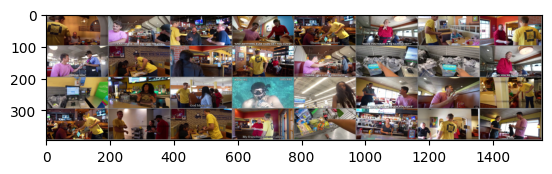

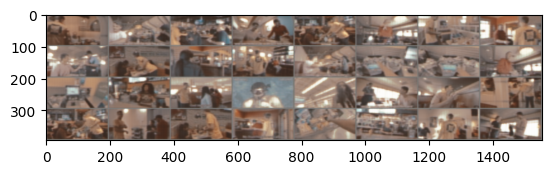

Loss: 46.8331




Input image(ABOVE) vs Reconstructed image(BELOW), for batch:[10/61]


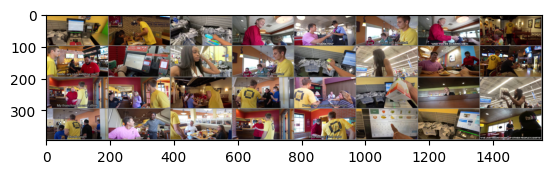

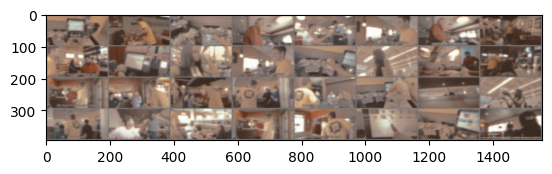

Loss: 44.5178




Input image(ABOVE) vs Reconstructed image(BELOW), for batch:[15/61]


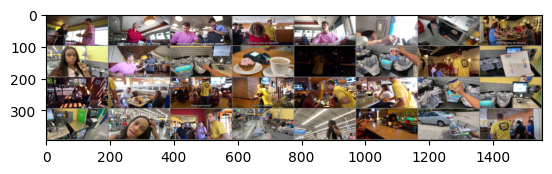

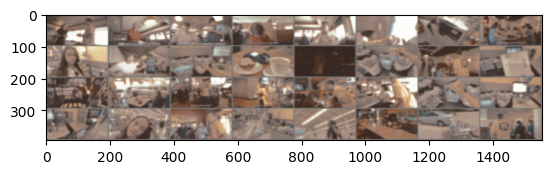

Loss: 44.4410




In [12]:
testloader = dm.test_dataloader()
testiter = iter(testloader)
# Load the latest checkpoint
loading_epoch = get_latest_epoch(checkpoint_dir)
print(f"loading epoch {loading_epoch} for testing")
resume(model, f"{str(checkpoint_dir)}/MS_SSIM_L1-epoch-{loading_epoch}.pth")
# testing the model
model.eval()
for i, (img_in, _ )in enumerate(testloader):
    with torch.no_grad():
        # can do img_out = model(img_in.to(device)).to(device) also
        img_out = model(img_in.to(device))
        loss = criterion(img_in.to(device), img_out.to(device)) 
    if (i+1) % 5 == 0:
       print (f"Input image(ABOVE) vs Reconstructed image(BELOW), for batch:[{i+1}/{len(trainloader)}]")
       imshow(torchvision.utils.make_grid(img_in.to("cpu")))
       imshow(torchvision.utils.make_grid(img_out.to("cpu")))
       print(f"Loss: {loss.item():.4f}")
       print("\n")

#### Plot training loss vs epoch

 checkpoints found: ['MS_SSIM_L1-epoch-100.pth', 'MS_SSIM_L1-epoch-110.pth', 'MS_SSIM_L1-epoch-120.pth', 'MS_SSIM_L1-epoch-130.pth', 'MS_SSIM_L1-epoch-140.pth', 'MS_SSIM_L1-epoch-150.pth', 'MS_SSIM_L1-epoch-160.pth', 'MS_SSIM_L1-epoch-170.pth', 'MS_SSIM_L1-epoch-180.pth', 'MS_SSIM_L1-epoch-190.pth', 'MS_SSIM_L1-epoch-200.pth', 'MS_SSIM_L1-epoch-50.pth', 'MS_SSIM_L1-epoch-60.pth', 'MS_SSIM_L1-epoch-70.pth', 'MS_SSIM_L1-epoch-80.pth', 'MS_SSIM_L1-epoch-90.pth']


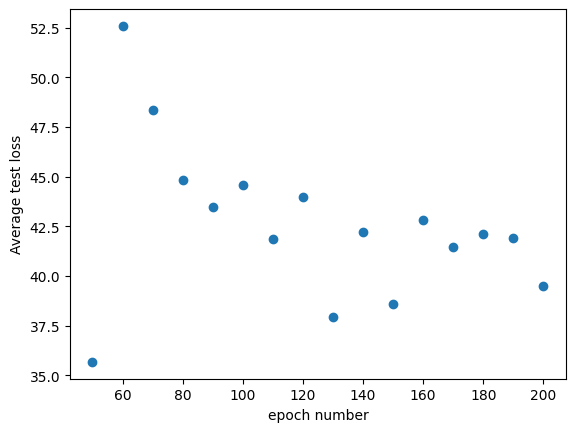

In [28]:
checkpoint_dir = 'checkpoints'
checkpoint_loss =[]
epoch_number = []
checkpoints = os.listdir(checkpoint_dir)
checkppoints = checkpoints.sort()
print(f' checkpoints found: {checkpoints}')
model = model.to(device)
# running the model on evaluation mode
model.eval()
for c in checkpoints:
    resume(model, f"{str(checkpoint_dir)}/{c}")
    c_loss = 0
    for (img_in, _ )in testloader:
        with torch.no_grad():
            img_out = model(img_in.to(device))
            loss = criterion(img_in.to(device), img_out.to(device))
            c_loss += loss.item()
    checkpoint_loss.append(c_loss/len(testloader))
    epoch_number.append(get_epoch(c))
plt.scatter(epoch_number, checkpoint_loss)
plt.xlabel("epoch number")
plt.ylabel("Average test loss")
plt.show()